In [2]:
import cv2 as cv
import os
import uuid
import time
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json
from matplotlib.patches import Rectangle
import random
import albumentations as alb
import shutil

%matplotlib inline

In [3]:
path = os.path.join('data','unlabeled_images')
num_images=10

cap = cv.VideoCapture(1)

if not cap.isOpened():
    print("Cannot open camera")
    exit()

#wait for video camera to setup
time.sleep(2)

for imgnum in range(num_images):
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    # Our operations on the frame come here
    # Display the resulting frame
    print(f"Capturing Image: {imgnum+1}")
    cv.imwrite(os.path.join(path,f"{str(uuid.uuid1())}.jpg"),frame)
    cv.imshow("frame",frame)
    time.sleep(1)
    if cv.waitKey(1) == ord('q'):
        break
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()
# I don't know why we need these 4 lines but it works
cv.waitKey(1)
cv.waitKey(1)
cv.waitKey(1)
cv.waitKey(1)

2023-12-01 13:26:54.940 Python[2182:166484] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Capturing Image: 1
Capturing Image: 2
Capturing Image: 3
Capturing Image: 4
Capturing Image: 5
Capturing Image: 6
Capturing Image: 7
Capturing Image: 8
Capturing Image: 9
Capturing Image: 10


-1

In [1]:
!labelme

zsh:1: command not found: labelme


In [5]:
# #run if all images labelled only by uncommenting

# unlabeled_img_path=os.path.join('data','unlabeled_images')
# labeled_img_path=os.path.join('data','labeled_images')
# for image in os.listdir(unlabeled_img_path):
#     if(image.split(".")[1]!='jpg'):
#         continue
#     source_file=os.path.join(unlabeled_img_path,image)
#     dest_file=os.path.join(labeled_img_path,image)
#     shutil.move(source_file, dest_file)

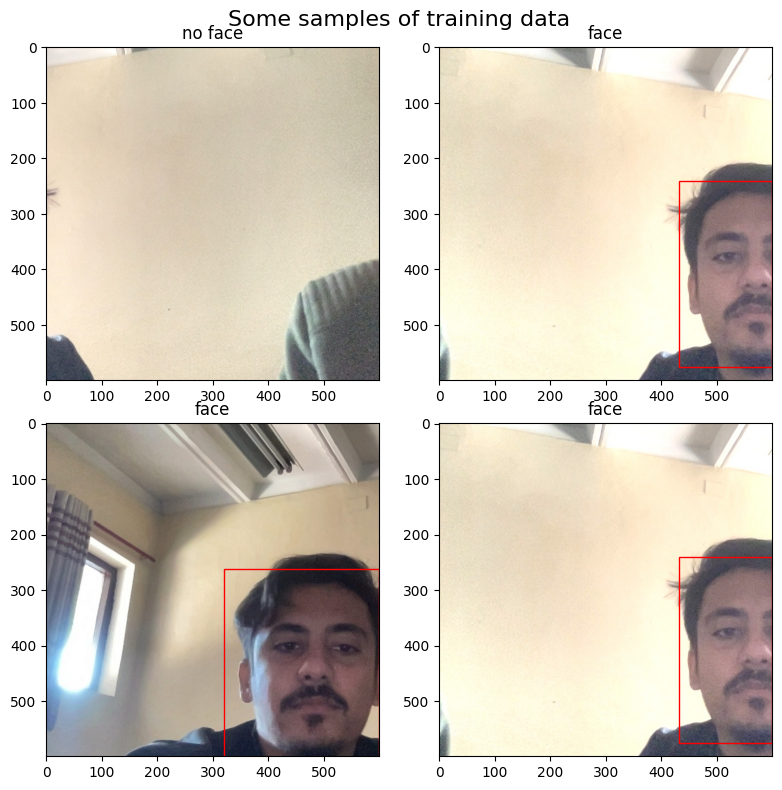

In [8]:
images = os.path.join('data','images')
labels=os.path.join('data','labels')

fig,axs=plt.subplots(2,2, figsize=(8,8))
file_names=os.listdir(images)

fig.suptitle('Some samples of training data', fontsize=16)
fig.tight_layout(pad=1.0)

for i in range(4):
    ind=random.randint(0, len(file_names)-1) #randint also includes the end of range
    name=file_names[ind]
    
    #check fo jpg 
    while(name.split(".")[1] != 'jpg'):
        ind=random.randint(0, len(file_names)-1)
        name=file_names[ind]
        
    name=name.split(".")[0]
    img = np.asarray(Image.open(os.path.join(images,f'{name}.jpg')))    
    
    try:
        with open(os.path.join(labels, f'{name}.json')) as f:
            label = json.load(f)
            points = np.array(label['shapes'][0]['points']).reshape(4,)
            x_min = points[0]
            y_min = points[1]
            w = points[2] - points[0]
            h = points[3] - points[1]
            tag=label['shapes'][0]['label']
    except FileNotFoundError:
        # If file not found, set default values for the bounding box
        x_min = y_min = 0
        w = h = 0.000001
        tag='no face'
    
    row = i // 2  # Calculate the row index in the subplot grid
    col = i % 2   # Calculate the column index in the subplot grid

    axs[row, col].imshow(img)
    axs[row, col].add_patch(Rectangle((x_min, y_min), w, h,
                                      edgecolor='red',
                                      fill=False))
    axs[row,col].title.set_text(tag)

In [7]:
images_path=os.path.join('data','labeled_images')
labels_path=os.path.join('data','labels')
store_path=os.path.join('data','images')
trash_path=os.path.join('data','used_images')

multiplier=3
#read documentation
transform_bbox = alb.Compose([
    alb.RandomCrop(width=600, height=600,p=1.0),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.2),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
],bbox_params=alb.BboxParams(format='pascal_voc',label_fields=['class_labels']))

transform_bbox_no_bbox = alb.Compose([
    alb.RandomCrop(width=600, height=600, p=1.0),
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.2),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.5),
])

files=os.listdir(images_path)

for file_name in files:
    if(file_name.split(".")[1]!='jpg'):
        continue
    #remove extension
    file_name=file_name.split(".")[0]
    
    image = cv.imread(os.path.join(images_path,f'{file_name}.jpg'))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    try:
        #if a label exists then bounding box adjustment needed
        with open(os.path.join(labels_path,f'{file_name}.json')) as label_file:
            label=json.load(label_file)
            #documentation says matrix so 1,4
            bboxes=np.array(label['shapes'][0]['points']).reshape(1,4)
            class_labels=['face']
            for i in range(multiplier):
                new_name=uuid.uuid1()
                
                
                transformed=transform_bbox(image=image,bboxes=bboxes,class_labels=class_labels)
                
                transformed_image = transformed['image']
                transformed_bboxes = transformed['bboxes']
                
                transformed_image = cv.cvtColor(transformed_image, cv.COLOR_RGB2BGR)
                
                cv.imwrite(os.path.join(store_path,f"{new_name}.jpg"),transformed_image)
                
                if(len(transformed_bboxes)==0):
                    #if bounding box out of range then no need to add label
                    continue
                #updating points
                #converting to list after resphaing
                label['shapes'][0]['points']=np.array(transformed_bboxes).reshape(2,2).tolist()
                #updating path
                label['imagePath']=f"../images/{new_name}.jpg"
                
                with open(os.path.join(labels_path,f"{new_name}.json"), "w") as outfile:
                    json.dump(label, outfile)
                    
    except FileNotFoundError:
        for i in range(multiplier):
            new_name=uuid.uuid1()

            transformed=transform_bbox_no_bbox(image=image)

            
            transformed_image = transformed['image']

            transformed_image = cv.cvtColor(transformed_image, cv.COLOR_RGB2BGR)
            
            cv.imwrite(os.path.join(store_path,f"{new_name}.jpg"),transformed_image)
    
    source_file=os.path.join(images_path,f'{file_name}.jpg')
    dest_file=os.path.join(trash_path,f'{file_name}.jpg')
    shutil.move(source_file, dest_file)


In [3]:
#train test val split
images_path=os.path.join('data','images')
labels_path=os.path.join('data','labels')
train_images_path=os.path.join('data','train','images')
test_images_path=os.path.join('data','test','images')
val_images_path=os.path.join('data','validation','images')
train_labels_path=os.path.join('data','train','labels')
test_labels_path=os.path.join('data','test','labels')
val_labels_path=os.path.join('data','validation','labels')

files=os.listdir(images_path)
num_files=len(files)
random.shuffle(files)

train_files=files[:int(num_files*0.6)] #60% train
test_files=files[int(num_files*0.6):int(num_files*0.8)] #20% test
val_files=files[int(num_files*0.8):] #20% val

for file_name in train_files:
    if(file_name.split(".")[1]!='jpg'):
        continue
    #remove extension
    file_name=file_name.split(".")[0]

    source_file=os.path.join(images_path,f'{file_name}.jpg')
    dest_file=os.path.join(train_images_path,f'{file_name}.jpg')
    shutil.move(source_file, dest_file)
    
    label_source_file = os.path.join(labels_path, f'{file_name}.json')
    if os.path.exists(label_source_file):
        source_file=os.path.join(labels_path,f'{file_name}.json')
        dest_file=os.path.join(train_labels_path,f'{file_name}.json')
        shutil.move(source_file, dest_file)

for file_name in test_files:
    if(file_name.split(".")[1]!='jpg'):
        continue
    #remove extension
    file_name=file_name.split(".")[0]

    source_file=os.path.join(images_path,f'{file_name}.jpg')
    dest_file=os.path.join(test_images_path,f'{file_name}.jpg')
    shutil.move(source_file, dest_file)
    
    label_source_file = os.path.join(labels_path, f'{file_name}.json')
    if os.path.exists(label_source_file):
        source_file=os.path.join(labels_path,f'{file_name}.json')
        dest_file=os.path.join(test_labels_path,f'{file_name}.json')
        shutil.move(source_file, dest_file)

for file_name in val_files:
    if(file_name.split(".")[1]!='jpg'):
        continue
    #remove extension
    file_name=file_name.split(".")[0]

    source_file=os.path.join(images_path,f'{file_name}.jpg')
    dest_file=os.path.join(val_images_path,f'{file_name}.jpg')
    shutil.move(source_file, dest_file)
    
    label_source_file = os.path.join(labels_path, f'{file_name}.json')
    if os.path.exists(label_source_file):
        source_file=os.path.join(labels_path,f'{file_name}.json')
        dest_file=os.path.join(val_labels_path,f'{file_name}.json')
        shutil.move(source_file, dest_file)

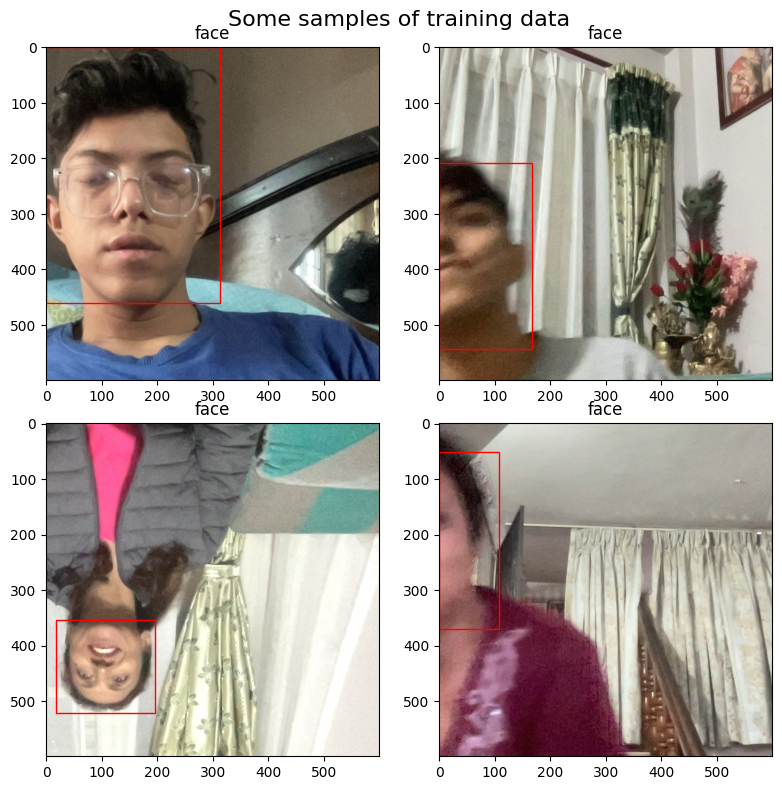

In [4]:
images = os.path.join('data','train','images')
labels=os.path.join('data','train','labels')

fig,axs=plt.subplots(2,2, figsize=(8,8))
file_names=os.listdir(images)

fig.suptitle('Some samples of training data', fontsize=16)
fig.tight_layout(pad=1.0)

for i in range(4):
    ind=random.randint(0, len(file_names)-1)
    name=file_names[ind]
    
    #check fo jpg 
    while(name.split(".")[1] != 'jpg'):
        ind=random.randint(0, len(file_names)-1)
        name=file_names[ind]
        
    name=name.split(".")[0]
    img = np.asarray(Image.open(os.path.join(images,f'{name}.jpg')))    
    
    try:
        with open(os.path.join(labels, f'{name}.json')) as f:
            label = json.load(f)
            points = np.array(label['shapes'][0]['points']).reshape(4,)
            x_min = points[0]
            y_min = points[1]
            w = points[2] - points[0]
            h = points[3] - points[1]
            tag=label['shapes'][0]['label']
    except FileNotFoundError:
        # If file not found, set default values for the bounding box
        x_min = y_min = 0
        w = h = 0.000001
        tag='no face'
    
    row = i // 2  # Calculate the row index in the subplot grid
    col = i % 2   # Calculate the column index in the subplot grid

    axs[row, col].imshow(img)
    axs[row, col].add_patch(Rectangle((x_min, y_min), w, h,
                                      edgecolor='red',
                                      fill=False))
    axs[row,col].title.set_text(tag)

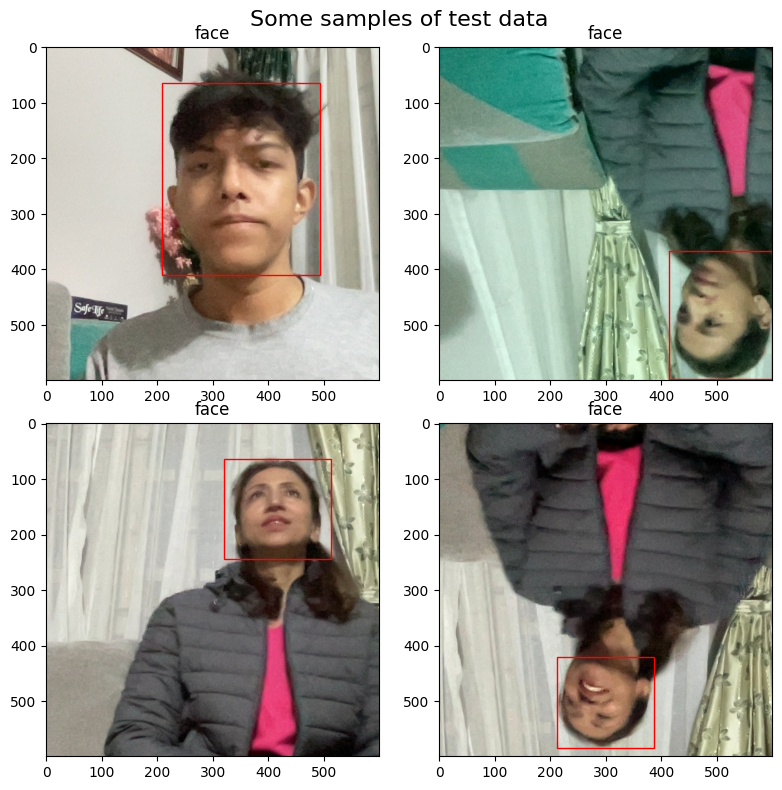

In [5]:
images = os.path.join('data','test','images')
labels=os.path.join('data','test','labels')

fig,axs=plt.subplots(2,2, figsize=(8,8))
file_names=os.listdir(images)

fig.suptitle('Some samples of test data', fontsize=16)
fig.tight_layout(pad=1.0)

for i in range(4):
    ind=random.randint(0, len(file_names)-1)
    name=file_names[ind]
    
    #check fo jpg 
    while(name.split(".")[1] != 'jpg'):
        ind=random.randint(0, len(file_names)-1)
        name=file_names[ind]
        
    name=name.split(".")[0]
    img = np.asarray(Image.open(os.path.join(images,f'{name}.jpg')))    
    
    try:
        with open(os.path.join(labels, f'{name}.json')) as f:
            label = json.load(f)
            points = np.array(label['shapes'][0]['points']).reshape(4,)
            x_min = points[0]
            y_min = points[1]
            w = points[2] - points[0]
            h = points[3] - points[1]
            tag=label['shapes'][0]['label']
    except FileNotFoundError:
        # If file not found, set default values for the bounding box
        x_min = y_min = 0
        w = h = 0.000001
        tag='no face'
    
    row = i // 2  # Calculate the row index in the subplot grid
    col = i % 2   # Calculate the column index in the subplot grid

    axs[row, col].imshow(img)
    axs[row, col].add_patch(Rectangle((x_min, y_min), w, h,
                                      edgecolor='red',
                                      fill=False))
    axs[row,col].title.set_text(tag)

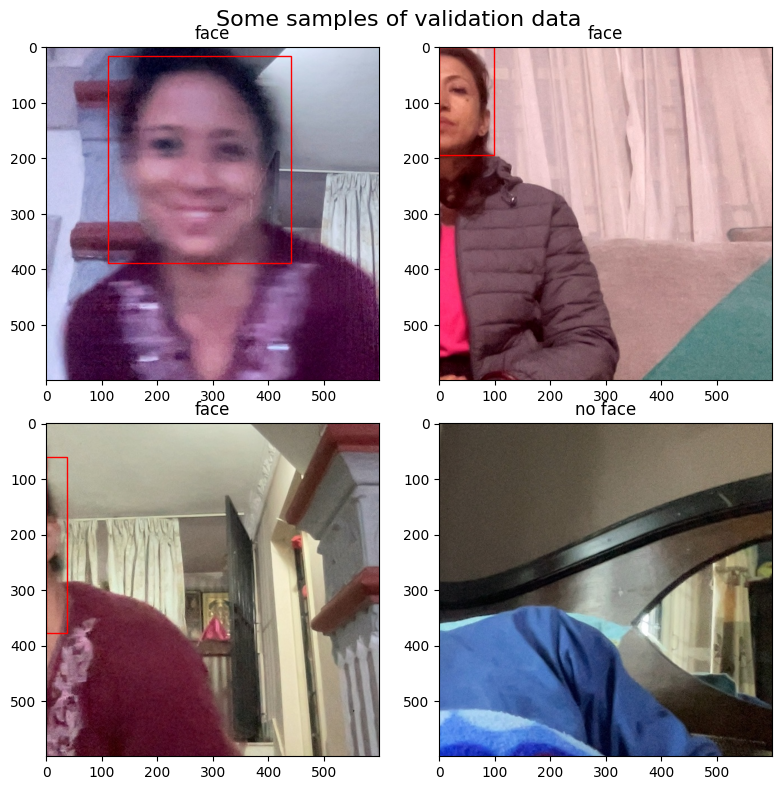

In [6]:
images = os.path.join('data','validation','images')
labels=os.path.join('data','validation','labels')

fig,axs=plt.subplots(2,2, figsize=(8,8))
file_names=os.listdir(images)

fig.suptitle('Some samples of validation data', fontsize=16)
fig.tight_layout(pad=1.0)

for i in range(4):
    ind=random.randint(0, len(file_names)-1)
    name=file_names[ind]
    
    #check fo jpg 
    while(name.split(".")[1] != 'jpg'):
        ind=random.randint(0, len(file_names)-1)
        name=file_names[ind]
        
    name=name.split(".")[0]
    img = np.asarray(Image.open(os.path.join(images,f'{name}.jpg')))    
    
    try:
        with open(os.path.join(labels, f'{name}.json')) as f:
            label = json.load(f)
            points = np.array(label['shapes'][0]['points']).reshape(4,)
            x_min = points[0]
            y_min = points[1]
            w = points[2] - points[0]
            h = points[3] - points[1]
            tag=label['shapes'][0]['label']
    except FileNotFoundError:
        # If file not found, set default values for the bounding box
        x_min = y_min = 0
        w = h = 0.000001
        tag='no face'
    
    row = i // 2  # Calculate the row index in the subplot grid
    col = i % 2   # Calculate the column index in the subplot grid

    axs[row, col].imshow(img)
    axs[row, col].add_patch(Rectangle((x_min, y_min), w, h,
                                      edgecolor='red',
                                      fill=False))
    axs[row,col].title.set_text(tag)